In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from tqdm.notebook import tqdm
import torchcde
from scipy.signal import find_peaks
import MulensModel as mm
import corner

torch.random.manual_seed(42)
np.random.seed(42)
plt.rcParams["font.family"] = "serif"
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')

In [2]:
with h5py.File('/work/hmzhao/irregular-lc/KMT-test.h5', mode='r') as dataset_file:
    Y = torch.tensor(dataset_file['Y'][...])
    X = torch.tensor(dataset_file['X'][...])

# filter nan
nanind = torch.where(~torch.isnan(X[:, 0, 1]))[0]
Y = Y[nanind]
X = X[nanind]
nanind = torch.where(Y[:, 2]>0)[0]
Y = Y[nanind]
X = X[nanind]
nanind = torch.where(Y[:, 2]<1)[0]
Y = Y[nanind]
X = X[nanind]

Y[:, 3:6] = torch.log10(Y[:, 3:6])
Y[:, -1] = torch.log10(Y[:, -1])
Y[:, 6] = Y[:, 6] / 180
Y = Y[:, 2:]
# Y = Y[:, [2, 4, 5, 6, 7]]
print('Shape of Y: ', Y.shape)

X[:, :, 1] = (X[:, :, 1] - 14.5 - 2.5 * Y[:, [-1]]) / 0.2
print(f'normalized X mean: {torch.mean(X[:, :, 1])}\nX std: {torch.mean(torch.std(X[:, :, 1], axis=0))}')

X = X[:, :, :2]
    
# CDE interpolation with log_sig
depth = 3; window_length = 5
logsig = torchcde.logsig_windows(X, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

Shape of Y:  torch.Size([99677, 6])
normalized X mean: -1.1799484138211669
X std: 1.0505892613255765


tensor(0.0321, dtype=torch.float64)

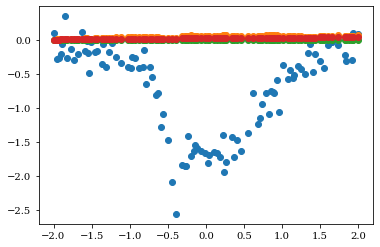

In [3]:
plt.scatter(logsig[0, :, 0], logsig[0, :, 1])
plt.scatter(logsig[0, :, 0], logsig[0, :, 2])
plt.scatter(logsig[0, :, 0], logsig[0, :, 3])
plt.scatter(logsig[0, :, 0], logsig[0, :, 4])
logsig[:, :, 2:].mean()

In [4]:
from model.cde_mdn import CDE_MDN

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

checkpt = torch.load('/work/hmzhao/experiments/cde_mdn/experiment_3.ckpt', map_location='cpu')
ckpt_args = checkpt['args']
state_dict = checkpt['state_dict']

output_dim = Y.shape[-1]
input_dim = logsig.shape[-1]
latent_dim = ckpt_args.latents

model = CDE_MDN(input_dim, latent_dim, output_dim).to(device)
# model = CDE_MDN(input_dim, latent_dim, output_dim, 32).to(device)
model_dict = model.state_dict()

# 1. filter out unnecessary keys
state_dict = {k: v for k, v in state_dict.items() if k in model_dict}
# 2. overwrite entries in the existing state dict
model_dict.update(state_dict) 
# 3. load the new state dict
model.load_state_dict(state_dict)
model.to(device)

CDE_MDN(
  (cde_func): CDEFunc(
    (linear1): Linear(in_features=32, out_features=1024, bias=True)
    (relu1): PReLU(num_parameters=1)
    (resblocks): Sequential(
      (0): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (1): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
      (2): ResBlock(
        (linear1): Linear(in_features=1024, out_features=1024, bias=True)
        (nonlinear1): PReLU(num_parameters=1)
        (linear2): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (relu2): PReLU(num_parameters=1)
    (linear2): Linear(in_features=1024, out_features=160, bias=True)
    (tanh): Tanh()
    (linear3): Linear(in_features=

In [43]:
def inference(model, total_size, batch_size, coeffs):
    num = total_size
    batchsize = batch_size
    n_gaussian = model.n_gaussian
    pis = torch.zeros((num, n_gaussian))
    locs = torch.zeros((num, n_gaussian, output_dim))
    scales = torch.zeros((num, n_gaussian, output_dim))
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(int(np.ceil(num / batchsize)))):
            batch = coeffs[i*batchsize:min(i*batchsize+batchsize, num)].float().to(device)
            pi, normal = model(batch)
            pis[i*batchsize:min(i*batchsize+batchsize, num)] = pi.probs.detach().cpu()
            locs[i*batchsize:min(i*batchsize+batchsize, num)] = normal.loc.detach().cpu()
            scales[i*batchsize:min(i*batchsize+batchsize, num)] = normal.scale.detach().cpu()
    return pis, locs, scales

def get_loglik(pi, loc, scale, x, margin_dim, exp=False):
    shape = x.shape
    loc = loc[..., margin_dim]
    scale = scale[..., margin_dim]
    normal = torch.distributions.Normal(loc, scale)
    x = x.reshape(-1, loc.shape[0], 1).tile(1, loc.shape[-1])
    loglik = normal.log_prob(x).reshape(*shape[:-1], -1)
    loglik = torch.logsumexp(torch.log(pi) + loglik, dim=-1)
    if exp:
        return torch.exp(loglik)
    return loglik

def get_peak_pred(pis, locs, scales, n_step=1000, verbose=False):
    num = len(pis); output_dim = locs.shape[-1]
    pred_global = torch.zeros((num, output_dim))
    pred_global_loglik = torch.zeros((num, output_dim))
    pred_close = torch.zeros((num, output_dim))
    pred_close_loglik = torch.zeros((num, output_dim))
    grid = [torch.linspace(0, 1, n_step),
            torch.linspace(-4, -2, n_step),
            torch.linspace(-4, 0, n_step),
            torch.linspace(-0.6, 0.6, n_step),
            torch.linspace(0, 2, n_step),
            torch.linspace(-1, 0, n_step)]
    if output_dim == 5:
        grid = [torch.linspace(0, 1, n_step),
            torch.linspace(-4, 0, n_step),
            torch.linspace(-0.6, 0.6, n_step),
            torch.linspace(0, 2, n_step),
            torch.linspace(-1, 0, n_step)]
    for dim in tqdm(range(output_dim)):
        param_list = grid[dim].reshape(-1, 1, 1).tile(1, num, 1) 
        loglik = get_loglik(pis, locs, scales, param_list, margin_dim=dim, exp=False).transpose(1, 0)
        for i in tqdm(range(num)):
            peaks = find_peaks(loglik[i])[0]
            if len(peaks) == 0:
                pred_global[i, dim] = grid[dim][torch.argmax(loglik[i])]
                pred_close[i, dim] = grid[dim][torch.argmax(loglik[i])]
                pred_global_loglik[i, dim] = torch.max(loglik[i])
                pred_close_loglik[i, dim] = torch.max(loglik[i])
                if verbose:
                    print('no peak found, use maximum instead')
                    plt.plot(grid[dim], loglik[i])
                    plt.vlines(Y[i, dim], 0, 10, color='red')
                    plt.vlines(grid[dim][torch.argmax(loglik[i])], 0, 10, color='blue')
                    print(Y[i, dim])
                    plt.show()
            else:
                order = torch.argsort(loglik[i, peaks], descending=True)
                global_peak = grid[dim][peaks[order[0]]]
                close_peak = grid[dim][peaks][torch.argmin((grid[dim][peaks] - Y[i, dim])**2)]
                pred_global[i, dim] = global_peak
                pred_close[i, dim] = close_peak
                pred_global_loglik[i, dim] = loglik[i][peaks[order[0]]]
                pred_close_loglik[i, dim] = loglik[i][peaks][torch.argmin((grid[dim][peaks] - Y[i, dim])**2)]
    return pred_global, pred_global_loglik, pred_close, pred_close_loglik
from matplotlib.offsetbox import AnchoredText
def plot_params(num, Y, pred_global, pred_global_loglik, pred_close, pred_close_loglik, title='params', plot_rho=True, save=None):
    if output_dim == 5:
        Y = torch.hstack([Y[:, :1], torch.zeros_like(Y[:, [0]]), Y[:, 1:]])
        pred_global = torch.hstack([pred_global[:, :1], torch.zeros_like(pred_global[:, [0]]), pred_global[:, 1:]])
        pred_close = torch.hstack([pred_close[:, :1], torch.zeros_like(pred_close[:, [0]]), pred_close[:, 1:]])
        pred_global_loglik = torch.hstack([pred_global_loglik[:, :1], torch.zeros_like(pred_global_loglik[:, [0]]), pred_global_loglik[:, 1:]])
    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 10), constrained_layout=True)
    axs[0, 0].axis('square')
    axs[0, 0].set_xlim(-4, 0)
    axs[0, 0].set_ylim(-4, 0)
    axs[0, 0].set_xlabel(r'actual $\lg q$')
    axs[0, 0].set_ylabel(r'predicted $\lg q$')
    axs[0, 0].scatter(Y[:num, 2], pred_global.numpy()[:num, 2], s=3, cmap='Blues', label='global', alpha=0.2, rasterized=True)
    axs[0, 0].scatter(Y[:num, 2], pred_close.numpy()[:num, 2], s=3, cmap='Oranges', label='close', alpha=0.2, rasterized=True)
    axs[0, 0].plot(np.linspace(-4, 0), np.linspace(-4, 0), color='b', linestyle='dashed')
    axs[0, 0].legend(loc='lower right')
    print('mse of log10q global: ', torch.mean((Y[:num, 2] -  pred_global.numpy()[:num, 2])**2).detach().cpu().item())
    print('mse of log10q close: ', torch.mean((Y[:num, 2] -  pred_close.numpy()[:num, 2])**2).detach().cpu().item())
    constraint_ind = pred_global_loglik[:num, 2]>np.log(2*1/4)
    print('constraint', torch.sum(constraint_ind).item()/num)
    print('correct', torch.sum(pred_global[:num, 2][constraint_ind]==pred_close[:num, 2][constraint_ind]).item()/torch.sum(constraint_ind).item())
    at = AnchoredText(
        "RMSE close=%.4f" % (np.sqrt(torch.mean((Y[:num, 2] -  pred_close.numpy()[:num, 2])**2).detach().cpu().item())), prop=dict(size=12), frameon=False, loc='upper left')
    axs[0, 0].add_artist(at)
    
    axs[0, 1].axis('square')
    axs[0, 1].set_xlim(np.log10(0.3), np.log10(3))
    axs[0, 1].set_ylim(np.log10(0.3), np.log10(3))
    axs[0, 1].set_xlabel(r'actual $\lg s$')
    axs[0, 1].set_ylabel(r'predicted $\lg s$')
    axs[0, 1].scatter(Y[:num, 3], pred_global.numpy()[:num, 3], s=3, cmap='Blues', label='global', alpha=0.2, rasterized=True)
    axs[0, 1].scatter(Y[:num, 3], pred_close.numpy()[:num, 3], s=3, cmap='Oranges', label='close', alpha=0.2, rasterized=True)
    axs[0, 1].plot(np.linspace(-0.6, 0.6), np.linspace(-0.6, 0.6), color='b', linestyle='dashed')
    axs[0, 1].legend(loc='lower right')
    print('mse of log10s global: ', torch.mean((Y[:num, 3] -  pred_global.numpy()[:num, 3])**2).detach().cpu().item())
    print('mse of log10s close: ', torch.mean((Y[:num, 3] -  pred_close.numpy()[:num, 3])**2).detach().cpu().item())
    constraint_ind = pred_global_loglik[:num, 3]>np.log(2*1/1.2)
    print('constraint', torch.sum(constraint_ind).item()/num)
    print('correct', torch.sum(pred_global[:num, 3][constraint_ind]==pred_close[:num, 3][constraint_ind]).item()/torch.sum(constraint_ind).item())
    at = AnchoredText(
        "RMSE close=%.4f" % (np.sqrt(torch.mean((Y[:num, 3] -  pred_close.numpy()[:num, 3])**2).detach().cpu().item())), prop=dict(size=12), frameon=False, loc='upper left')
    axs[0, 1].add_artist(at)
    
    axs[0, 2].axis('square')
    axs[0, 2].set_xlim(0, 1)
    axs[0, 2].set_ylim(0, 1)
    axs[0, 2].set_xlabel(r'actual $u_0$')
    axs[0, 2].set_ylabel(r'predicted $u_0$')
    axs[0, 2].scatter(Y[:num, 0], pred_global.numpy()[:num, 0], s=3, cmap='Blues', label='global', alpha=0.2, rasterized=True)
    axs[0, 2].scatter(Y[:num, 0], pred_close.numpy()[:num, 0], s=3, cmap='Oranges', label='close', alpha=0.2, rasterized=True)
    axs[0, 2].plot(np.linspace(0, 1), np.linspace(0, 1), color='b', linestyle='dashed')
    axs[0, 2].legend(loc='lower right')
    print('mse of u0: ', torch.mean((Y[:num, 0] -  pred_global.numpy()[:num, 0])**2).detach().cpu().item())
    print('mse of u0: ', torch.mean((Y[:num, 0] -  pred_close.numpy()[:num, 0])**2).detach().cpu().item())
    constraint_ind = pred_global_loglik[:num, 0]>np.log(2*1/1)
    print('constraint', torch.sum(constraint_ind).item()/num)
    print('correct', torch.sum(pred_global[:num, 0][constraint_ind]==pred_close[:num, 0][constraint_ind]).item()/torch.sum(constraint_ind).item())
    at = AnchoredText(
        "RMSE close=%.4f" % (np.sqrt(torch.mean((Y[:num, 0] -  pred_close.numpy()[:num, 0])**2).detach().cpu().item())), prop=dict(size=12), frameon=False, loc='upper left')
    axs[0, 2].add_artist(at)

    if plot_rho:
        axs[1, 0].axis('square')
        axs[1, 0].set_xlim(-4, -2)
        axs[1, 0].set_ylim(-4, -2)
        axs[1, 0].set_xlabel(r'actual $\lg \rho$')
        axs[1, 0].set_ylabel(r'predicted $\lg \rho$')
        axs[1, 0].scatter(Y[:num, 1], pred_global.numpy()[:num, 1], s=3, cmap='Blues', label='global', alpha=0.2, rasterized=True)
        axs[1, 0].scatter(Y[:num, 1], pred_close.numpy()[:num, 1], s=3, cmap='Oranges', label='close', alpha=0.2, rasterized=True)
        axs[1, 0].plot(np.linspace(-4, -2), np.linspace(-4, -2), color='b', linestyle='dashed')
        axs[1, 0].legend(loc='lower right')
        print('mse of log10rho global: ', torch.mean((Y[:num, 1] -  pred_global.numpy()[:num, 1])**2).detach().cpu().item())
        print('mse of log10rho close: ', torch.mean((Y[:num, 1] -  pred_close.numpy()[:num, 1])**2).detach().cpu().item())
        constraint_ind = pred_global_loglik[:num, 1]>np.log(2*1/2)
        print('constraint', torch.sum(constraint_ind).item()/num)
        if torch.sum(constraint_ind).item() > 0:
            print('correct', torch.sum(pred_global[:num, 1][constraint_ind]==pred_close[:num, 1][constraint_ind]).item()/torch.sum(constraint_ind).item())
        at = AnchoredText(
            "RMSE close=%.4f" % (np.sqrt(torch.mean((Y[:num, 1] -  pred_close.numpy()[:num, 1])**2).detach().cpu().item())), prop=dict(size=12), frameon=False, loc='upper left')
        axs[1, 0].add_artist(at)

    axs[1, 1].axis('square')
    axs[1, 1].set_xlim(0, 360)
    axs[1, 1].set_ylim(0, 360)
    axs[1, 1].set_xlabel(r'actual $\alpha$')
    axs[1, 1].set_ylabel(r'predicted $\alpha$')
    axs[1, 1].scatter(Y[:num, 4]*180, pred_global.numpy()[:num, 4]*180, s=3, cmap='Blues', label='global', alpha=0.2, rasterized=True)
    axs[1, 1].scatter(Y[:num, 4]*180, pred_close.numpy()[:num, 4]*180, s=3, cmap='Oranges', label='close', alpha=0.2, rasterized=True)
    axs[1, 1].plot(np.linspace(0, 360), np.linspace(0, 360), color='b', linestyle='dashed')
    axs[1, 1].legend(loc='lower right')
    print('mse of alpha global: ', torch.mean((Y[:num, 4]*180 -  pred_global.numpy()[:num, 4]*180)**2).detach().cpu().item())
    print('mse of alpha close: ', torch.mean((Y[:num, 4]*180 -  pred_close.numpy()[:num, 4]*180)**2).detach().cpu().item())
    constraint_ind = pred_global_loglik[:num, 4]>np.log(2*1/2)
    print('constraint', torch.sum(constraint_ind).item()/num)
    print('correct', torch.sum(pred_global[:num, 4][constraint_ind]==pred_close[:num, 4][constraint_ind]).item()/torch.sum(constraint_ind).item())
    at = AnchoredText(
        "RMSE close=%.3f" % np.sqrt((torch.mean((Y[:num, 4] -  pred_close.numpy()[:num, 4])**2).detach().cpu().item())*180), prop=dict(size=12), frameon=False, loc='upper left')
    axs[1, 1].add_artist(at)


    axs[1, 2].axis('square')
    axs[1, 2].set_xlim(-1, 0)
    axs[1, 2].set_ylim(-1, 0)
    axs[1, 2].set_xlabel(r'actual $\lg f_s$')
    axs[1, 2].set_ylabel(r'predicted $\lg f_s$')
    axs[1, 2].scatter(Y[:num, 5], pred_global.numpy()[:num, 5], s=3, cmap='Blues', label='global', alpha=0.2, rasterized=True)
    axs[1, 2].scatter(Y[:num, 5], pred_close.numpy()[:num, 5], s=3, cmap='Oranges', label='close', alpha=0.2, rasterized=True)
    axs[1, 2].plot(np.linspace(-1, 0), np.linspace(-1, 0), color='b', linestyle='dashed')
    axs[1, 2].legend(loc='lower right')
    print('mse of log10fs global: ', torch.mean((Y[:num, 5] -  pred_global.numpy()[:num, 5])**2).detach().cpu().item())
    print('mse of log10fs close: ', torch.mean((Y[:num, 5] -  pred_close.numpy()[:num, 5])**2).detach().cpu().item())
    constraint_ind = pred_global_loglik[:num, 5]>np.log(2*1/1)
    print('constraint', torch.sum(constraint_ind).item()/num)
    print('correct', torch.sum(pred_global[:num, 5][constraint_ind]==pred_close[:num, 5][constraint_ind]).item()/torch.sum(constraint_ind).item())
    at = AnchoredText(
        "RMSE close=%.4f" % np.sqrt((torch.mean((Y[:num, 5] -  pred_close.numpy()[:num, 5])**2).detach().cpu().item())), prop=dict(size=12), frameon=False, loc='upper left')
    axs[1, 2].add_artist(at)
    
    fig.suptitle(title)

    if save != None:
        plt.savefig(save)
    
    plt.show()
    

def simulate_lc(t_0, t_E, u_0, lgrho, lgq, lgs, alpha_180, lgfs, relative_uncertainty=0, n_points=1000, orig=False):
    fs = 10**lgfs
    parameters = {
            't_0': t_0,
            't_E': t_E,
            'u_0': u_0,
            'rho': 10**lgrho, 
            'q': 10**lgq, 
            's': 10**lgs, 
            'alpha': alpha_180*180,
        }
    modelmm = mm.Model(parameters, coords=None)
    times = modelmm.set_times(t_start=parameters['t_0']-2*parameters['t_E'], t_stop=parameters['t_0']+2*parameters['t_E'], n_epochs=n_points)
    modelmm.set_magnification_methods([parameters['t_0']-2*parameters['t_E'], 'VBBL', parameters['t_0']+2*parameters['t_E']])
    magnification = modelmm.get_magnification(times)
    flux = 1000 * (magnification + (1-fs)/fs)
    flux *= 1 + relative_uncertainty * np.random.randn(len(flux))
    if orig:
        mag = (22 - 2.5 * np.log10(flux) - 14.5 - 2.5*np.log10(fs))
    else:
        mag = (22 - 2.5 * np.log10(flux) - 14.5 - 2.5*np.log10(fs)) / 0.2
    lc = np.stack([times, mag], axis=-1)
    return lc


In [6]:
size = 4096 * 4

In [8]:
pis, locs, scales = inference(model, size, 4096, coeffs)

  0%|          | 0/4 [00:00<?, ?it/s]

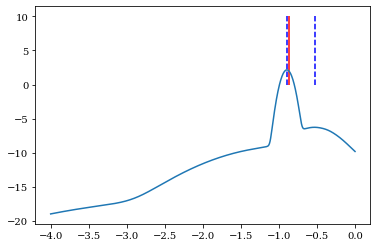

In [9]:
i = 0; dim = 2
if output_dim == 5:
    dim = 1
qgrid = torch.linspace(-4, 0, 1000)
qlist = qgrid.reshape(-1, 1, 1).tile(1, 1, 1)
plt.plot(qgrid, get_loglik(pis[[i]], locs[[i]], scales[[i]], qlist, margin_dim=dim, exp=False)[:, 0])
peaks = find_peaks(get_loglik(pis[[i]], locs[[i]], scales[[i]], qlist, margin_dim=dim, exp=False).transpose(1, 0)[0])[0]
plt.vlines(Y[i, dim], 0, 10, color='red')
plt.vlines(qgrid[peaks], 0, 10, color='blue', linestyles='dashed')

In [10]:
pred_global, pred_global_loglik, pred_close, pred_close_loglik = get_peak_pred(pis, locs, scales, n_step=1000)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

In [11]:
if output_dim == 5:
    print(pred_global_loglik.sum(dim=1).mean(), pred_close_loglik.sum(dim=1).mean())
else:
    print(pred_global_loglik[:, [0, 2, 3, 4, 5]].sum(dim=1).mean(), pred_close_loglik[:, [0, 2, 3, 4, 5]].sum(dim=1).mean())

tensor(12.1033) tensor(11.5832)


mse of log10q global:  0.053018051090508
mse of log10q close:  0.026272466096989
constraint 0.998046875
correct 0.9311399217221135
mse of log10s global:  0.00977359321788038
mse of log10s close:  0.0010687287159054008
constraint 0.99554443359375
correct 0.9037459383238305
mse of u0:  0.007918742665725531
mse of u0:  0.002844350799596363
constraint 0.99139404296875
correct 0.9193498737917872
mse of log10rho global:  0.3258819189589212
mse of log10rho close:  0.3258819189589212
constraint 0.0001220703125
correct 1.0
mse of alpha global:  4872.689804332189
mse of alpha close:  598.4707634816166
constraint 0.97314453125
correct 0.8383090817862519
mse of log10fs global:  0.0018979858316886138
mse of log10fs close:  0.0011997078155551474
constraint 0.99725341796875
correct 0.9553216231103495


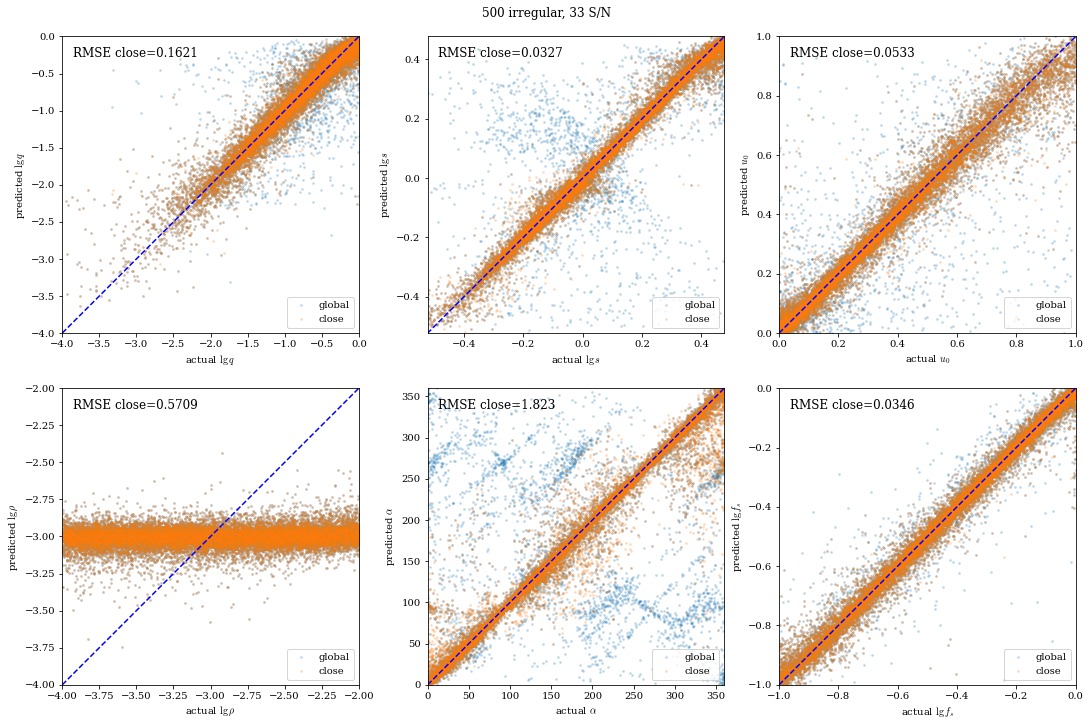

In [50]:
plot_params(size, Y, pred_global, pred_global_loglik, pred_close, pred_close_loglik, title='500 irregular, 33 S/N', plot_rho=True, save='./500ir33SN.pdf')

# Subsample

In [13]:
n_points = 100
subsample_ind = torch.argsort(torch.rand_like(X[:, :, 0]), dim=1)[:, :n_points]
X_sub = X[torch.arange(X.shape[0]).unsqueeze(-1), subsample_ind]
order = np.argsort(X_sub[:, :, 0].numpy(), axis=1)
X_sub = X_sub[torch.arange(X_sub.shape[0]).unsqueeze(-1), order]

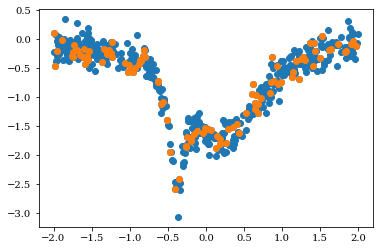

In [14]:
i = 0
plt.scatter(X[i, :, 0], X[i, :, 1])
plt.scatter(X_sub[i, :, 0], X_sub[i, :, 1])

In [15]:
# CDE interpolation with log_sig
depth = 3; window_length = max(n_points//100, 1)
logsig = torchcde.logsig_windows(X_sub, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

In [16]:
pis_sub, locs_sub, scales_sub = inference(model, size, 4096, coeffs)

  0%|          | 0/4 [00:00<?, ?it/s]

In [17]:
pred_sub = get_peak_pred(pis_sub, locs_sub, scales_sub)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

mse of log10q global:  0.19399881510108719
mse of log10q close:  0.10307768475570063
constraint 0.99847412109375
correct 0.8038388654563238
mse of log10s global:  0.031438549007395275
mse of log10s close:  0.003960519318772405
constraint 0.9979248046875
correct 0.7056269113149847
mse of u0:  0.020979851890021935
mse of u0:  0.008129762464964437
constraint 0.98834228515625
correct 0.7984931760637313
mse of log10rho global:  0.34620462439442623
mse of log10rho close:  0.34620462439442623
constraint 0.0
mse of alpha global:  9425.335269471938
mse of alpha close:  965.7678131184243
constraint 0.97821044921875
correct 0.6517127347600924
mse of log10fs global:  0.007438845185932107
mse of log10fs close:  0.0045378012638389855
constraint 0.9874267578125
correct 0.8674125355420942


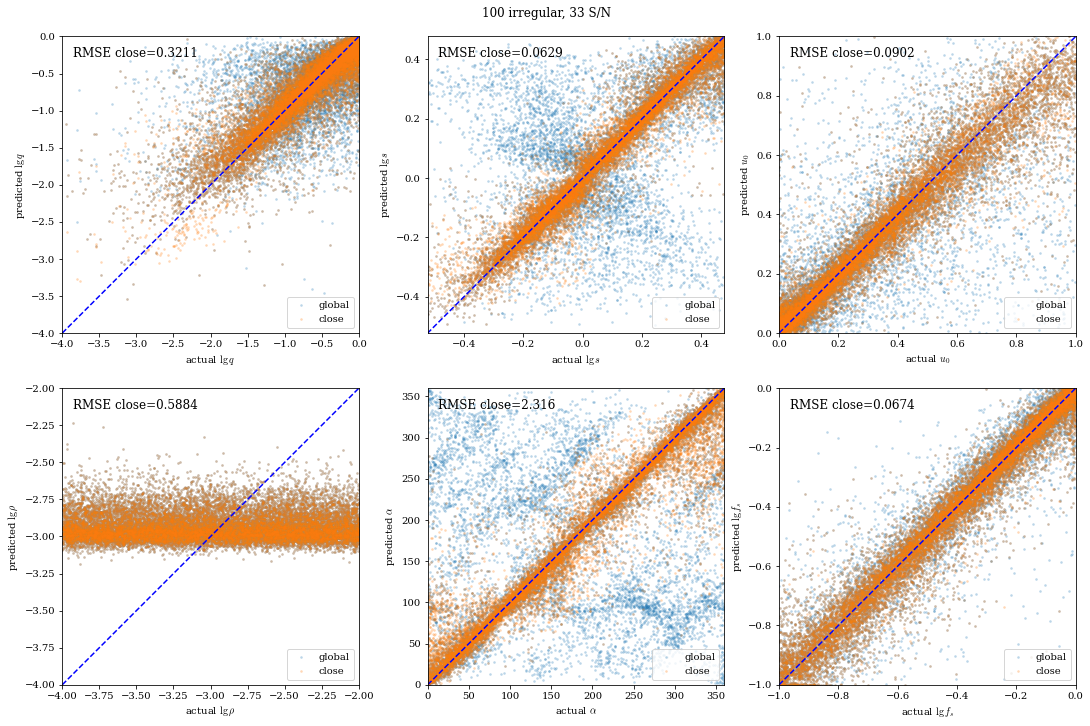

In [51]:
plot_params(size, Y, *pred_sub, title=f'{n_points} irregular, 33 S/N', save=f'./{n_points}ir33SN.pdf')

In [19]:
pred_sub[1].sum(dim=1).mean(), pred_sub[3].sum(dim=1).mean()

(tensor(11.0025), tensor(8.5574))

In [ ]:
n_points_list = [500, 200, 100, 50, 20, 10]
mse_global = np.zeros((len(n_points_list), output_dim))
mse_close = np.zeros((len(n_points_list), output_dim))
loglik_global = np.zeros((len(n_points_list), output_dim))
loglik_close = np.zeros((len(n_points_list), output_dim))
for i in tqdm(range(len(n_points_list))):
    n_points = n_points_list[i]
    subsample_ind = torch.argsort(torch.rand_like(X[:, :, 0]), dim=1)[:, :n_points]
    X_sub = X[torch.arange(X.shape[0]).unsqueeze(-1), subsample_ind]
    order = np.argsort(X_sub[:, :, 0].numpy(), axis=1)
    X_sub = X_sub[torch.arange(X_sub.shape[0]).unsqueeze(-1), order]

    # CDE interpolation with log_sig
    depth = 3; window_length = max(n_points//100, 1)
    logsig = torchcde.logsig_windows(X_sub, depth, window_length=window_length)
    coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

    pis, locs, scales = inference(model, size, 4096, coeffs)
    pred_sub = get_peak_pred(pis, locs, scales)

    mse_global[i] = torch.mean((pred_sub[0] - Y[:size])**2, dim=0).numpy()
    mse_close[i] = torch.mean((pred_sub[2] - Y[:size])**2, dim=0).numpy()
    loglik_global[i] = torch.mean(pred_sub[1], dim=0).numpy()
    loglik_close[i] = torch.mean(pred_sub[3], dim=0).numpy()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

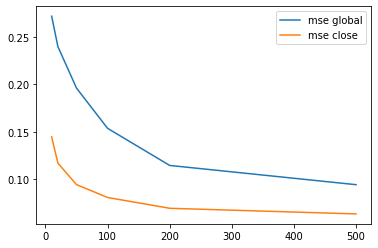

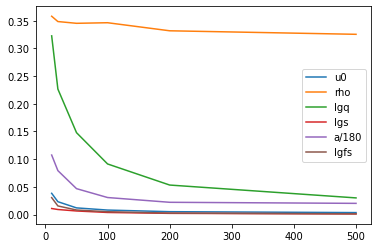

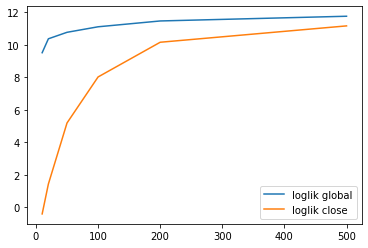

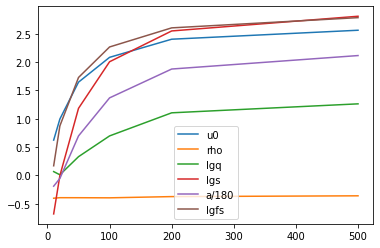

In [ ]:
plt.plot(n_points_list, mse_global.mean(1), label='mse global')
plt.plot(n_points_list, mse_close.mean(1), label='mse close')
plt.legend()
plt.show()
plt.plot(n_points_list, mse_close, label=['u0', 'rho', 'lgq', 'lgs', 'a/180', 'lgfs'])
plt.legend()
plt.show()
plt.plot(n_points_list, loglik_global.sum(1), label='loglik global')
plt.plot(n_points_list, loglik_close.sum(1), label='loglik close')
plt.legend()
plt.show()
plt.plot(n_points_list, loglik_close, label=['u0', 'rho', 'lgq', 'lgs', 'a/180', 'lgfs'])
plt.legend()
plt.show()

# Gap
Gap length: 5 days = 1/6 tE = 1/24 4tE

In [20]:
n_chunks = 25
gap_len = int(500 / n_chunks)
gap_left = torch.randint(0, X.shape[1]-gap_len, (len(X),))
X_gap = torch.zeros((X.shape[0], X.shape[1]-gap_len, X.shape[2]))
for i in tqdm(range(len(X))):
    left, gap, right = torch.split(X[i], [gap_left[i], gap_len, X.shape[1]-gap_left[i]-gap_len], dim=0)
    lc = torch.vstack([left, right])
    X_gap[i] = lc

  0%|          | 0/99677 [00:00<?, ?it/s]

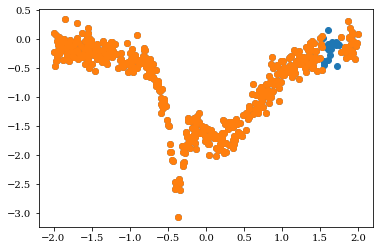

In [21]:
i = 0
plt.scatter(X[i, :, 0], X[i, :, 1])
plt.scatter(X_gap[i, :, 0], X_gap[i, :, 1])

In [22]:
# CDE interpolation with log_sig
depth = 3; window_length = max(X_gap.shape[1]//100, 1)
logsig = torchcde.logsig_windows(X_gap, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)

In [23]:
pis_gap, locs_gap, scales_gap = inference(model, size, 4096, coeffs)

  0%|          | 0/4 [00:00<?, ?it/s]

In [24]:
pred_gap = get_peak_pred(pis_gap, locs_gap, scales_gap)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

mse of log10q global:  0.06610200486931321
mse of log10q close:  0.03178682934799792
constraint 0.9981689453125
correct 0.9183074477192125
mse of log10s global:  0.011182943657308663
mse of log10s close:  0.0012824076123296249
constraint 0.995849609375
correct 0.8877175778377053
mse of u0:  0.008934997265986403
mse of u0:  0.003383316953241733
constraint 0.99090576171875
correct 0.909578072066523
mse of log10rho global:  0.3258397339329743
mse of log10rho close:  0.3258397339329743
constraint 0.000244140625
correct 1.0
mse of alpha global:  5160.55432415947
mse of alpha close:  643.9625449912176
constraint 0.97259521484375
correct 0.82654534044556
mse of log10fs global:  0.00242092094330437
mse of log10fs close:  0.001466984714387485
constraint 0.9962158203125
correct 0.948168116652371


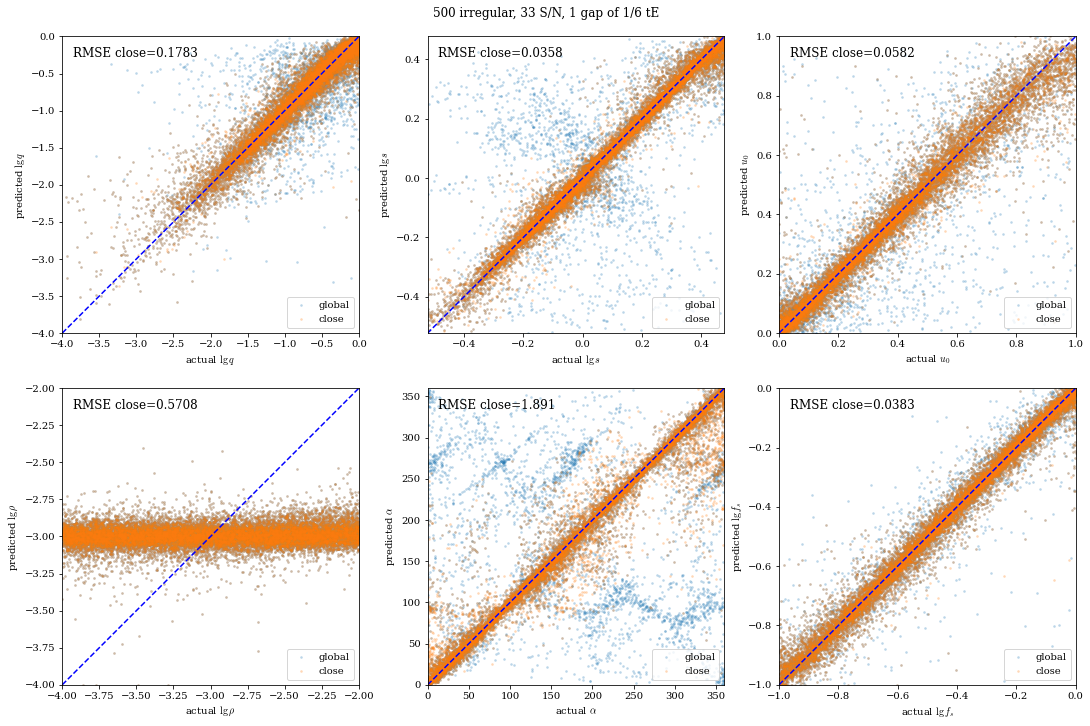

In [46]:
plot_params(size, Y, *pred_gap, title='500 irregular, 33 S/N, 1 gap of 1/6 tE', save='./500ir33SN1gap.pdf')

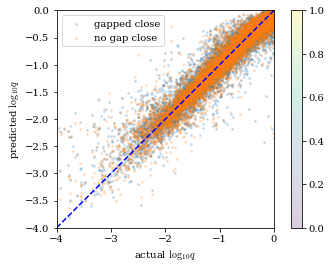

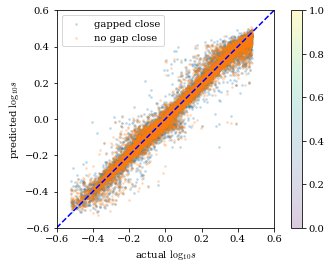

In [26]:
num = size
plt.axis('square')
plt.xlim(-4, 0)
plt.ylim(-4, 0)
plt.xlabel(r'actual $\log_{10}q$')
plt.ylabel(r'predicted $\log_{10}q$')
plt.scatter(Y[:num, 2], pred_gap[2].numpy()[:num, 2], s=3, cmap='Oranges', label='gapped close', alpha=0.2)
plt.scatter(Y[:num, 2], pred_close.numpy()[:num, 2], s=3, cmap='Blues', label='no gap close', alpha=0.2)
plt.plot(np.linspace(-4, 0), np.linspace(-4, 0), color='b', linestyle='dashed')
plt.colorbar()
plt.legend()
plt.show()
plt.axis('square')
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.xlabel(r'actual $\log_{10}s$')
plt.ylabel(r'predicted $\log_{10}s$')
plt.scatter(Y[:num, 3], pred_gap[2].numpy()[:num, 3], s=3, cmap='Oranges', label='gapped close', alpha=0.2)
plt.scatter(Y[:num, 3], pred_close.numpy()[:num, 3], s=3, cmap='Blues', label='no gap close', alpha=0.2)
plt.plot(np.linspace(-0.6, 0.6), np.linspace(-0.6, 0.6), color='b', linestyle='dashed')
plt.colorbar()
plt.legend()
plt.show()

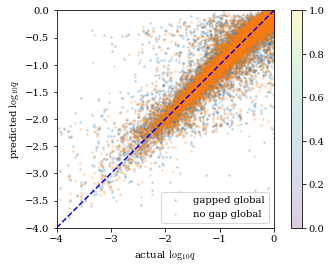

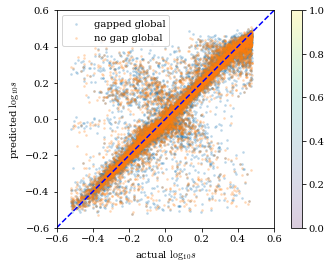

In [27]:
plt.axis('square')
plt.xlim(-4, 0)
plt.ylim(-4, 0)
plt.xlabel(r'actual $\log_{10}q$')
plt.ylabel(r'predicted $\log_{10}q$')
plt.scatter(Y[:num, 2], pred_gap[0].numpy()[:num, 2], s=3, cmap='Oranges', label='gapped global', alpha=0.2)
plt.scatter(Y[:num, 2], pred_global.numpy()[:num, 2], s=3, cmap='Blues', label='no gap global', alpha=0.2)
plt.plot(np.linspace(-4, 0), np.linspace(-4, 0), color='b', linestyle='dashed')
plt.colorbar()
plt.legend()
plt.show()
plt.axis('square')
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.xlabel(r'actual $\log_{10}s$')
plt.ylabel(r'predicted $\log_{10}s$')
plt.scatter(Y[:num, 3], pred_gap[0].numpy()[:num, 3], s=3, cmap='Oranges', label='gapped global', alpha=0.2)
plt.scatter(Y[:num, 3], pred_global.numpy()[:num, 3], s=3, cmap='Blues', label='no gap global', alpha=0.2)
plt.plot(np.linspace(-0.6, 0.6), np.linspace(-0.6, 0.6), color='b', linestyle='dashed')
plt.colorbar()
plt.legend()
plt.show()

In [28]:
pred_gap[1].sum(dim=1).mean(), pred_gap[3].sum(dim=1).mean()

(tensor(11.6865), tensor(11.0499))

In [29]:
i = torch.mean((pred_close - pred_global)**2, dim=-1).sort()[1][-10:]
i, #Y[i], pred_close[i], pred_global[i]

(tensor([15952,   373,  9792,  3235,  1993, 15151,   801,   477,  4974, 11729]),)

(tensor([ 0.0142, -3.9927, -2.9833,  0.0078,  0.0817, -0.9380],
        dtype=torch.float64),
 tensor([ 0.0090, -3.0531, -2.8108, -0.0126,  0.2843, -0.9520]),
 tensor([ 0.0060, -2.9590, -2.9510, -0.0090,  0.3744, -0.9429]))

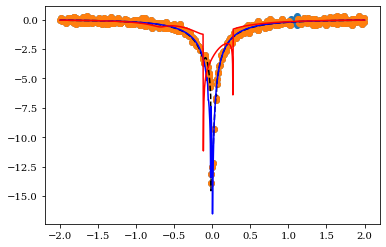

In [30]:
i = 3235
# plt.xlim(-0.5, 0.5)
plt.scatter(X[i, :, 0], X[i, :, 1])
plt.scatter(X_gap[i, :, 0], X_gap[i, :, 1])
lc_true = simulate_lc(0, 1, *Y[i].tolist())
lc_pred = simulate_lc(0, 1, *pred_close[i].tolist())
lc_pred_gap = simulate_lc(0, 1, *pred_global[i].tolist())
plt.plot(lc_true[:, 0], lc_true[:, 1], color='black', linestyle='dashed')
plt.plot(lc_pred[:, 0], lc_pred[:, 1], color='blue', )
plt.plot(lc_pred_gap[:, 0], lc_pred_gap[:, 1], color='red', )
Y[i], pred_close[i], pred_gap[2][i]

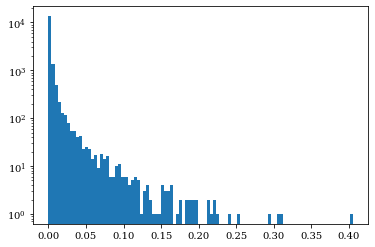

In [31]:
plt.hist((torch.mean(X[:size, :, 1], dim=1) - torch.mean(X_gap[:size, :, 1], dim=1)).numpy()**2, bins=100, log=True)
plt.show()

In [32]:
ind = (torch.mean(X[:, :, 1], dim=1) - torch.mean(X_gap[:, :, 1], dim=1)).numpy()**2 > 0.05
ind[size:] = False

In [33]:
torch.mean((Y[ind][:size] - pred_gap[2][ind[:size]])**2, dim=1).argsort()

tensor([144, 156, 222, 219, 227,  82,  52, 148, 191, 120, 109, 106,  27,  77,
        115,  95,  76,  23, 111, 240,  75, 178, 149, 102, 174,  11, 235, 135,
        176, 126, 229, 212,  38, 171, 160, 231,  21, 189,  25, 162,  45,  53,
        186,   0, 188,  78, 122, 241, 139,  46, 118, 204,  54,   3,  71,  48,
        182, 223,  30, 121,  51,  14, 209, 152,  94, 185,  68, 197, 103,  89,
         62,  87, 164,  20,  43,  41, 116, 221, 153, 193, 155, 218,  35,   7,
        206,  47,  84, 208,  63, 181,  59, 104,   8, 132, 183, 161, 199, 125,
        150, 163, 127, 137, 205, 211, 172, 140,  81, 200, 237, 234,   1, 198,
          6, 113,  55, 157, 105, 239, 195, 196, 159, 110,  74,  85,  79,  69,
         18,  72, 108, 142, 215,  15, 228, 167, 143, 141, 173,  91, 202,  60,
        217, 129,  37, 114, 130,  40,  24,  67, 230, 226, 146,   4, 131,  73,
         28,  13,  50, 169, 165,  98, 138, 168,   9,  34,  65,  56, 117,  32,
        216, 184, 192,  80, 201, 136, 101, 166,  29,  66,  26, 1

Gap recovered: 77**, 53**, 68*, 20, 140, 228*, 146, 28, 50, 26, 194*, 97*

parameters: u0, lgrho, lgq, lgs, alpha, lgfs
ground truth:  [ 0.08252024 -2.99659797 -1.07022848  0.1238179   0.74459931 -0.14806532]
pred no gap:  [ 0.07307307 -2.8808808  -1.089089    0.13993995  0.7827828  -0.14014015]
pred gap close:  [ 0.07807808 -2.8168168  -1.065065    0.13273275  0.7587587  -0.13713714]
pred gap global:  [ 0.07807808 -2.8168168  -1.065065    0.13273275  0.7587587  -0.13713714]
77


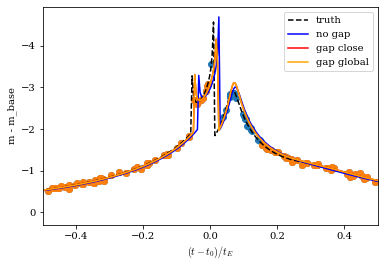

In [34]:
# n=112+14*9
# for i in torch.mean((Y[ind][:size] - pred_gap[2][ind[:size]])**2, dim=1).argsort()[n:n+14]:
i = 77
plt.xlabel(r'$(t - t_0)/t_E$')
plt.ylabel(r'm - m_base')
plt.xlim(-0.5, 0.5)
plt.scatter(X[ind][i, :, 0], X[ind][i, :, 1]*0.2)
plt.scatter(X_gap[ind][i, :, 0], X_gap[ind][i, :, 1]*0.2)
lc_true = simulate_lc(0, 1, *Y[ind][i].tolist(), orig=True)
lc_pred = simulate_lc(0, 1, *pred_global[ind[:size]][i].tolist(), orig=True)
lc_pred_gap = simulate_lc(0, 1, *pred_gap[2][ind[:size]][i].tolist(), orig=True)
lc_pred_gap_g = simulate_lc(0, 1, *pred_gap[0][ind[:size]][i].tolist(), orig=True)
plt.plot(lc_true[:, 0], lc_true[:, 1], color='black', linestyle='dashed', label='truth')
plt.plot(lc_pred[:, 0], lc_pred[:, 1], color='blue', label='no gap')
plt.plot(lc_pred_gap[:, 0], lc_pred_gap[:, 1], color='red', label='gap close')
plt.plot(lc_pred_gap_g[:, 0], lc_pred_gap_g[:, 1], color='orange', label='gap global')
print('parameters: u0, lgrho, lgq, lgs, alpha, lgfs')
print('ground truth: ', Y[ind][i].numpy())
print('pred no gap: ', pred_global[ind[:size]][i].numpy())
print('pred gap close: ', pred_gap[2][ind[:size]][i].numpy())
print('pred gap global: ', pred_gap[0][ind[:size]][i].numpy())
print(i)
plt.gca().invert_yaxis()
plt.legend()
plt.show()

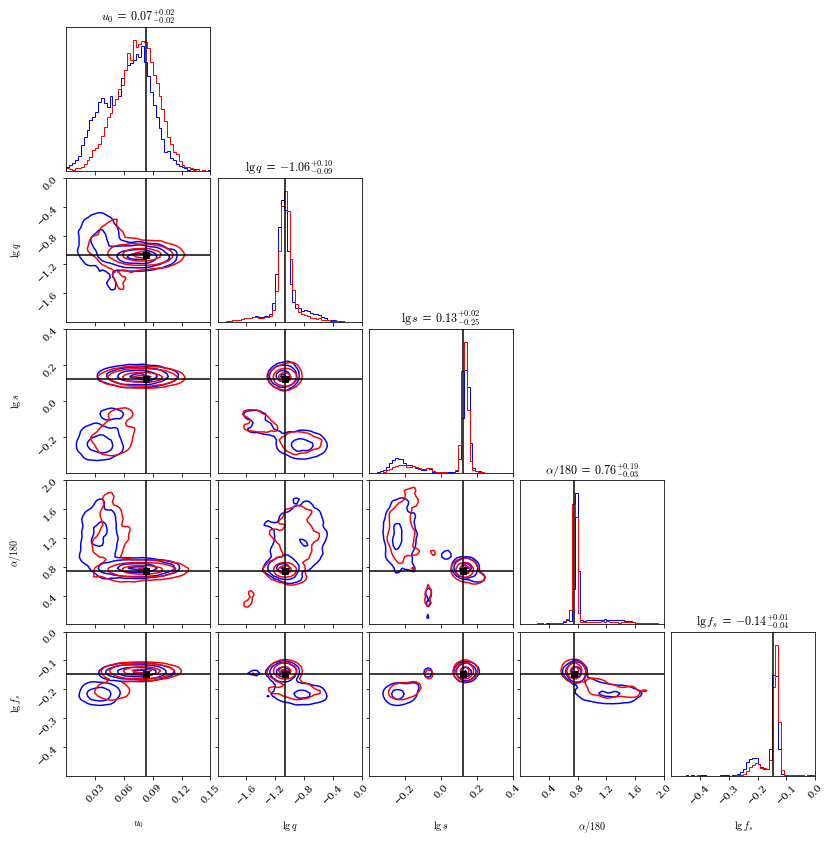

In [34]:
n = int(1e4)

pi = pis[ind[:size]][i]; loc = locs[ind[:size]][i]; scale = scales[ind[:size]][i]
pi = torch.tile(pi, (n, 1)); loc = torch.tile(loc, (n, 1, 1)); scale = torch.tile(scale, (n, 1, 1))
normal = torch.distributions.Normal(loc, scale)
pi_dist = torch.distributions.OneHotCategorical(probs=pi)
sample = model.sample(pi_dist, normal).numpy()
sample = np.delete(sample, 1, axis=1)

pi = pis_gap[ind[:size]][i]; loc = locs_gap[ind[:size]][i]; scale = scales_gap[ind[:size]][i]
pi = torch.tile(pi, (n, 1)); loc = torch.tile(loc, (n, 1, 1)); scale = torch.tile(scale, (n, 1, 1))
normal = torch.distributions.Normal(loc, scale)
pi_dist = torch.distributions.OneHotCategorical(probs=pi)
sample_gap = model.sample(pi_dist, normal).numpy()
loglik = normal.log_prob(torch.tensor(sample_gap).unsqueeze(1).expand_as(normal.loc))
loglik = torch.sum(loglik, dim=2)
loglik = torch.logsumexp(torch.log(pi_dist.probs) + loglik, dim=1)
np.savetxt('samples.csv', np.hstack([sample_gap, loglik.reshape(-1, 1)]), fmt='%.5f', delimiter=',', header='u0, lgrho, lgq, lgs, alpha/180, lgfs, loglik')
sample_gap = np.delete(sample_gap, 1, axis=1)

truths = Y[ind][i].numpy()
truths = np.delete(truths, 1)

# range_p = [(0.8, 1.2), (-1.6, -1), (0.35, 0.45), (1.1, 1.2), (-0.2, 0.2)] # 53
range_p = [(0, 0.15), (-2, 0), (-0.4, 0.4), (0, 2), (-0.5, 0)] # 77
# range_p = None
sigma_level = 1-np.exp(-0.5)
fig = corner.corner(sample, labels=[r"$u_0$", r"$\lg q$", r"$\lg s$", r"$\alpha/180$", r"$\lg f_s$"],
            # quantiles=[0.16, 0.5, 0.84], 
            smooth=1,
            bins=50,
            range=range_p,
            show_titles=True, title_kwargs={"fontsize": 12},
            fill_contours=False, color='blue', no_fill_contours=True,
            plot_datapoints=False, plot_density=False,
            # levels=[sigma_level, 0.7],
            )
corner.corner(sample_gap, fig=fig, labels=[r"$u_0$", r"$\lg q$", r"$\lg s$", r"$\alpha/180$", r"$\lg f_s$"],
            # quantiles=[0.16, 0.5, 0.84], 
            smooth=1,
            bins=50,
            range=range_p,
            show_titles=True, title_kwargs={"fontsize": 12},
            truths=truths, truth_color='black', 
            fill_contours=False, color='red',  no_fill_contours=True,
            plot_datapoints=False, plot_density=False,
            # levels=[sigma_level, 0.7],
            )
# plt.legend()
plt.show()

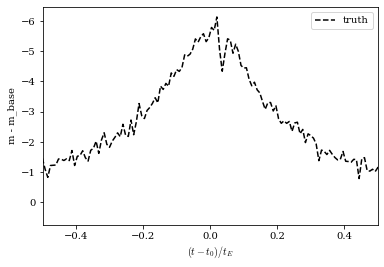

In [35]:
plt.xlabel(r'$(t - t_0)/t_E$')
plt.ylabel(r'm - m_base')
plt.xlim(-0.5, 0.5)
test_p = [0.1, -2.301, -3.301, -0, 110/180, np.log10(0.2)]
lc_true = simulate_lc(0, 1, *test_p, orig=False, n_points=500, relative_uncertainty=0.03)
# lc_pred = simulate_lc(0, 1, *pred_global[ind[:size]][i].tolist(), orig=True)
# lc_pred_gap = simulate_lc(0, 1, *pred_gap[2][ind[:size]][i].tolist(), orig=True)
# lc_pred_gap_g = simulate_lc(0, 1, *pred_gap[0][ind[:size]][i].tolist(), orig=True)
plt.plot(lc_true[:, 0], lc_true[:, 1], color='black', linestyle='dashed', label='truth')
# plt.plot(lc_pred[:, 0], lc_pred[:, 1], color='blue', label='no gap')
# plt.plot(lc_pred_gap[:, 0], lc_pred_gap[:, 1], color='red', label='gap close')
# plt.plot(lc_pred_gap_g[:, 0], lc_pred_gap_g[:, 1], color='orange', label='gap global')
# print('parameters: u0, lgrho, lgq, lgs, alpha, lgfs')
# print('ground truth: ', Y[ind][i].numpy())
# print('pred no gap: ', pred_global[ind[:size]][i].numpy())
# print('pred gap close: ', pred_gap[2][ind[:size]][i].numpy())
# print('pred gap global: ', pred_gap[0][ind[:size]][i].numpy())
# print(i)
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [36]:
X_test = torch.tensor(lc_true.reshape(1, -1, 2)).float()
depth = 3; window_length = max(X_test.shape[1]//100, 1)
logsig = torchcde.logsig_windows(X_test, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)
with torch.no_grad():
    pi, normal = model(coeffs.to(device))

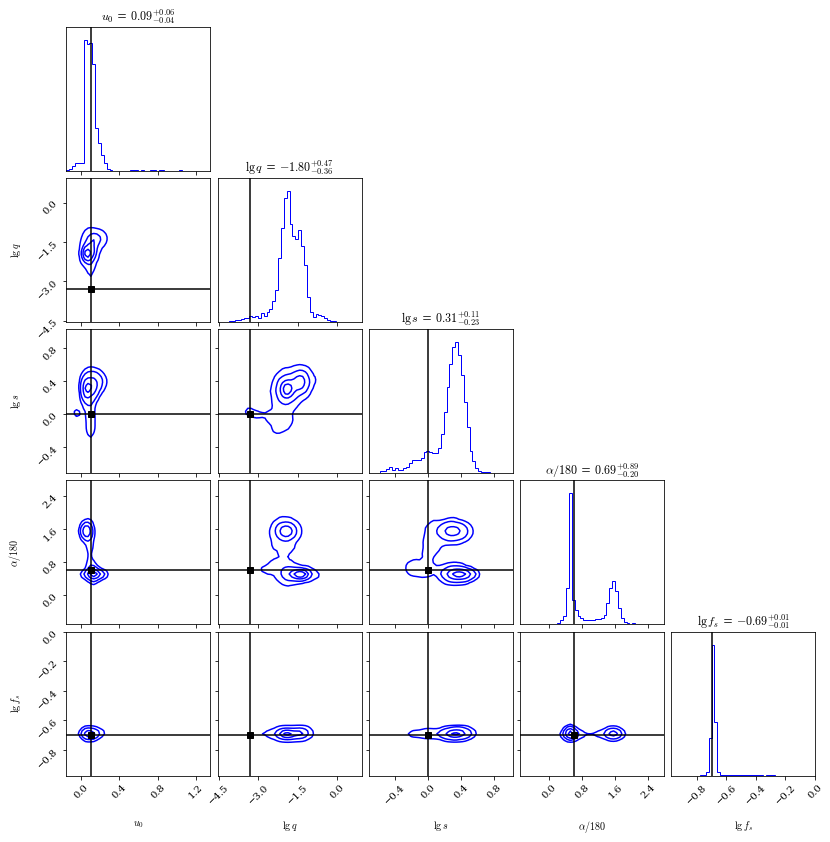

In [37]:
n = int(1e4)

pi = pi.probs.cpu(); loc = normal.loc.cpu(); scale = normal.scale.cpu()
pi = torch.tile(pi, (n, 1)); loc = torch.tile(loc, (n, 1, 1)); scale = torch.tile(scale, (n, 1, 1))
normal = torch.distributions.Normal(loc, scale)
pi_dist = torch.distributions.OneHotCategorical(probs=pi)
sample = model.sample(pi_dist, normal).numpy()
sample = np.delete(sample, 1, axis=1)

# pi = pis_gap[ind[:size]][i]; loc = locs_gap[ind[:size]][i]; scale = scales_gap[ind[:size]][i]
# pi = torch.tile(pi, (n, 1)); loc = torch.tile(loc, (n, 1, 1)); scale = torch.tile(scale, (n, 1, 1))
# normal = torch.distributions.Normal(loc, scale)
# pi_dist = torch.distributions.OneHotCategorical(probs=pi)
# sample_gap = model.sample(pi_dist, normal).numpy()
# loglik = normal.log_prob(torch.tensor(sample_gap).unsqueeze(1).expand_as(normal.loc))
# loglik = torch.sum(loglik, dim=2)
# loglik = torch.logsumexp(torch.log(pi_dist.probs) + loglik, dim=1)
# np.savetxt('samples.csv', np.hstack([sample_gap, loglik.reshape(-1, 1)]), fmt='%.5f', delimiter=',', header='u0, lgrho, lgq, lgs, alpha/180, lgfs, loglik')
# sample_gap = np.delete(sample_gap, 1, axis=1)

truths = np.array(test_p)
truths = np.delete(truths, 1)

# range_p = [(0.8, 1.2), (-1.6, -1), (0.35, 0.45), (1.1, 1.2), (-0.2, 0.2)] # 53
# range_p = [(0, 0.15), (-2, 0), (-0.4, 0.4), (0, 2), (-0.5, 0)] # 77
range_p = None
sigma_level = 1-np.exp(-0.5)
fig = corner.corner(sample, labels=[r"$u_0$", r"$\lg q$", r"$\lg s$", r"$\alpha/180$", r"$\lg f_s$"],
            # quantiles=[0.16, 0.5, 0.84], 
            smooth=1,
            bins=50,
            range=range_p,
            show_titles=True, title_kwargs={"fontsize": 12},
            truths=truths, truth_color='black', 
            fill_contours=False, color='blue', no_fill_contours=True,
            plot_datapoints=False, plot_density=False,
            # levels=[sigma_level, 0.7],
            )
# corner.corner(sample_gap, fig=fig, labels=[r"$u_0$", r"$\lg q$", r"$\lg s$", r"$\alpha/180$", r"$\lg f_s$"],
#             # quantiles=[0.16, 0.5, 0.84], 
#             smooth=1,
#             bins=50,
#             range=range_p,
#             show_titles=True, title_kwargs={"fontsize": 12},
#             truths=truths, truth_color='black', 
#             fill_contours=False, color='red',  no_fill_contours=True,
#             plot_datapoints=False, plot_density=False,
#             # levels=[sigma_level, 0.7],
#             )
# plt.legend()
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

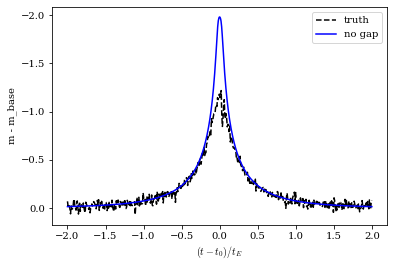

In [38]:
pred_test = get_peak_pred(pi[[0]], loc[[0]], scale[[0]])[0].flatten()
plt.xlabel(r'$(t - t_0)/t_E$')
plt.ylabel(r'm - m_base')
# plt.xlim(-0.5, 0.5)
test_p = [0.1, -2.301, -3.301, -0, 110/180, np.log10(0.2)]
lc_true = simulate_lc(0, 1, *test_p, orig=True, n_points=500, relative_uncertainty=0.03)
lc_pred = simulate_lc(0, 1, *(pred_test.tolist()), orig=True)
# lc_pred_gap = simulate_lc(0, 1, *pred_gap[2][ind[:size]][i].tolist(), orig=True)
# lc_pred_gap_g = simulate_lc(0, 1, *pred_gap[0][ind[:size]][i].tolist(), orig=True)
plt.plot(lc_true[:, 0], lc_true[:, 1], color='black', linestyle='dashed', label='truth')
plt.plot(lc_pred[:, 0], lc_pred[:, 1], color='blue', label='no gap')
# plt.plot(lc_pred_gap[:, 0], lc_pred_gap[:, 1], color='red', label='gap close')
# plt.plot(lc_pred_gap_g[:, 0], lc_pred_gap_g[:, 1], color='orange', label='gap global')
# print('parameters: u0, lgrho, lgq, lgs, alpha, lgfs')
# print('ground truth: ', Y[ind][i].numpy())
# print('pred no gap: ', pred_global[ind[:size]][i].numpy())
# print('pred gap close: ', pred_gap[2][ind[:size]][i].numpy())
# print('pred gap global: ', pred_gap[0][ind[:size]][i].numpy())
# print(i)
plt.gca().invert_yaxis()
plt.legend()
plt.show()

In [253]:
from scipy.optimize import minimize
x = pred_global[ind[:size]][i].tolist()
x[3] = -0.4
# x = [0.05, -2.816816806793213, -0.9, -0.24, 1.22, -0.22]
pi = pis[ind[:size]][i]; loc = locs[ind[:size]][i]; scale = scales[ind[:size]][i]
# pi = pis_gap[ind[:size]][i]; loc = locs_gap[ind[:size]][i]; scale = scales_gap[ind[:size]][i]
pi = torch.tile(pi, (n, 1)); loc = torch.tile(loc, (n, 1, 1)); scale = torch.tile(scale, (n, 1, 1))
normal = torch.distributions.Normal(loc, scale)
pi_dist = torch.distributions.OneHotCategorical(probs=pi)
result = minimize(lambda x: model.mdn_loss(pi_dist, normal, torch.tensor(x).reshape(-1, 6)), x)
print(result)

      fun: -9.560304460732526
 hess_inv: array([[ 3.80401611e-05,  4.25880733e-04, -1.11635014e-05,
        -1.39091560e-05,  3.58076218e-05, -5.13149730e-06],
       [ 4.25880733e-04,  2.40342761e-01,  1.77160874e-02,
        -5.28511929e-03,  4.69830500e-04, -1.57031497e-03],
       [-1.11635014e-05,  1.77160874e-02,  2.72658589e-02,
         2.04159331e-04, -8.58224342e-04,  1.89286446e-05],
       [-1.39091560e-05, -5.28511929e-03,  2.04159331e-04,
         1.00407056e-03, -1.46357420e-04,  4.57553916e-05],
       [ 3.58076218e-05,  4.69830500e-04, -8.58224342e-04,
        -1.46357420e-04,  8.63464396e-02, -1.00963254e-05],
       [-5.13149730e-06, -1.57031497e-03,  1.89286446e-05,
         4.57553916e-05, -1.00963254e-05,  1.19486919e-04]])
      jac: array([-9.29832458e-06,  0.00000000e+00, -3.57627869e-07,  4.88758087e-06,
        0.00000000e+00,  1.45435333e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 147
      nit: 15
     njev: 2

parameters: u0, lgrho, lgq, lgs, alpha, lgfs
ground truth:  [ 0.09807598 -3.12932717 -1.71259524  0.28449352  1.1236783  -0.24157655]
pred no gap:  [ 0.1021021  -3.0470471  -1.7657658   0.2924925   1.1531532  -0.24024025] prob density:  167341.52
pred gap close:  [ 0.11511511 -3.0570571  -1.6976976   0.2804805   1.1951952  -0.23323323] prob density:  465.12793
pred gap second:  [ 0.11117535 -3.06756953 -0.99334267 -0.34256337  1.21580687 -0.23754606] prob density:  14190.165890277709
82


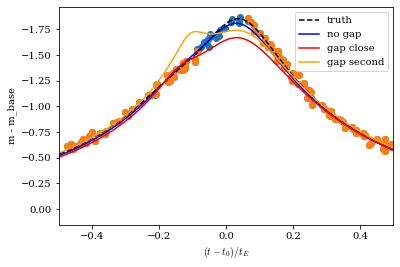

In [254]:
plt.xlabel(r'$(t - t_0)/t_E$')
plt.ylabel(r'm - m_base')
plt.xlim(-0.5, 0.5)
plt.scatter(X[ind][i, :, 0], X[ind][i, :, 1]*0.2)
plt.scatter(X_gap[ind][i, :, 0], X_gap[ind][i, :, 1]*0.2)
lc_true = simulate_lc(0, 1, *Y[ind][i].tolist(), orig=True)
lc_pred = simulate_lc(0, 1, *pred_global[ind[:size]][i].tolist(), orig=True)
lc_pred_gap = simulate_lc(0, 1, *pred_gap[2][ind[:size]][i].tolist(), orig=True)
# pred_gap_sec = pred_gap[0][ind[:size]][i].tolist()
# pred_gap_sec[0] = 0.05; pred_gap_sec[2] = -0.9; pred_gap_sec[3] = -0.24; pred_gap_sec[4] = 1.22; pred_gap_sec[5] = -0.22
pred_gap_sec = result['x']
lc_pred_gap_sec = simulate_lc(0, 1, *pred_gap_sec, orig=True)
# lc_pred_gap_g = simulate_lc(0, 1, *pred_gap[0][ind[:size]][i].tolist(), orig=True)
plt.plot(lc_true[:, 0], lc_true[:, 1], color='black', linestyle='dashed', label='truth')
plt.plot(lc_pred[:, 0], lc_pred[:, 1], color='blue', label='no gap')
plt.plot(lc_pred_gap[:, 0], lc_pred_gap[:, 1], color='red', label='gap close')
plt.plot(lc_pred_gap_sec[:, 0], lc_pred_gap_sec[:, 1], color='orange', label='gap second')
# plt.plot(lc_pred_gap_g[:, 0], lc_pred_gap_g[:, 1], color='orange', label='gap global')
print('parameters: u0, lgrho, lgq, lgs, alpha, lgfs')
print('ground truth: ', Y[ind][i].numpy())
print('pred no gap: ', pred_global[ind[:size]][i].numpy(), 'prob density: ', np.exp(pred_global_loglik[ind[:size]][i].numpy().sum()))
print('pred gap close: ', pred_gap[2][ind[:size]][i].numpy(), 'prob density: ', np.exp(pred_gap[3][ind[:size]][i].numpy().sum()))
print('pred gap second: ', pred_gap_sec, 'prob density: ', np.exp(-result['fun']))
# print('pred gap global: ', pred_gap[0][ind[:size]][i].numpy())
print(i)
plt.gca().invert_yaxis()
plt.legend()
plt.show()

# Even

In [ ]:
X_even = np.zeros((size, X.shape[-2], X.shape[-1]))
for i in tqdm(range(size)):
    lc = simulate_lc(0, 1, *Y[i].tolist(), relative_uncertainty=0.03, n_points=500)
    X_even[i] = lc
np.save('./KMT-even.npy', X_even)

  0%|          | 0/16384 [00:00<?, ?it/s]

In [35]:
X_even = np.load('./KMT-even.npy')

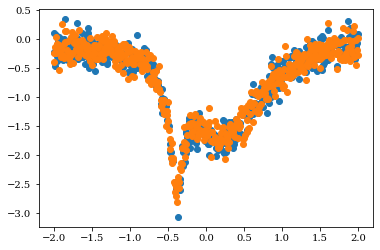

(0.0076868533270071015, 1.9878191484637504e-17)

In [36]:
i = 0
plt.scatter(X[i, :, 0], X[i, :, 1])
plt.scatter(X_even[i, :, 0], X_even[i, :, 1])
plt.show()
np.diff(X[i, :, 0]).std(), np.diff(X_even[i, :, 0]).std()

In [37]:
X_even = torch.tensor(X_even)
# CDE interpolation with log_sig
depth = 3; window_length = max(X_even.shape[1]//100, 1)
logsig = torchcde.logsig_windows(X_even, depth, window_length=window_length)
coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(logsig)
pis, locs, scales = inference(model, size, 4096, coeffs)

  0%|          | 0/4 [00:00<?, ?it/s]

In [38]:
pred_even = get_peak_pred(pis, locs, scales)

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

mse of log10q global:  0.04366894702301845
mse of log10q close:  0.021788903832608862
constraint 0.99774169921875
correct 0.939010215941763
mse of log10s global:  0.00810658733987537
mse of log10s close:  0.0009722611477529898
constraint 0.99407958984375
correct 0.9171732056241174
mse of u0:  0.007252005446822253
mse of u0:  0.0025002304937482654
constraint 0.99102783203125
correct 0.9235696249307138
mse of log10rho global:  0.32469859123070566
mse of log10rho close:  0.32469859123070566
constraint 0.0
mse of alpha global:  4444.84405670514
mse of alpha close:  546.6991254059847
constraint 0.9713134765625
correct 0.8543420887269071
mse of log10fs global:  0.001612798779538325
mse of log10fs close:  0.0010210255369154366
constraint 0.99755859375
correct 0.9580274106705825


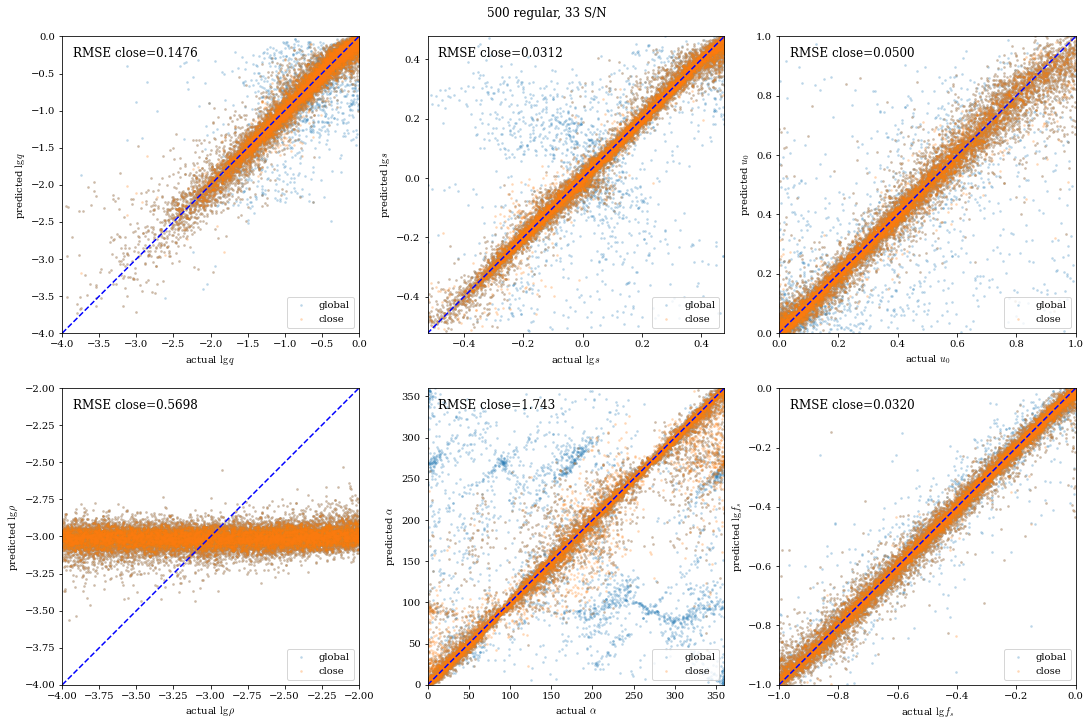

In [48]:
plot_params(size, Y, *pred_even, '500 regular, 33 S/N', save='./500reg33SN.pdf')

In [40]:
pred_even[1].sum(dim=1).mean(), pred_even[3].sum(dim=1).mean()

(tensor(11.8777), tensor(11.4573))

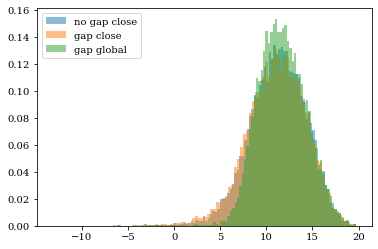

In [41]:
plt.hist(pred_close_loglik.numpy().sum(1), bins=100, density=True, label='no gap close', alpha=0.5)
plt.hist(pred_gap[3].numpy().sum(1), bins=100, density=True, label='gap close', alpha=0.5)
plt.hist(pred_gap[1].numpy().sum(1), bins=100, density=True, label='gap global', alpha=0.5)
plt.legend()
plt.show()